<a href="https://colab.research.google.com/github/aldrenjunior/final-project-Heart-Failure-Prediction/blob/main/Final_project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from plotly.offline import plot, iplot, init_notebook_mode
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import DBSCAN
from sklearn import metrics
from collections import Counter
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Heart Failure Prediction (Predição de insuficiência cardíaca)

* dataRaw original: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data
* Modelo de referencia: https://www.kaggle.com/nayansakhiya/heart-fail-analysis-and-quick-prediction

Nesse dataRaw existem alguns fatores que afetam o 'DEATH_EVENT' com informações da pessoa como: idade, sexo, pressão arterial, se é fumante, se é diabetico, fração de ejeção, creatinina fosfoquinase, soro_creatinina, soro_sódico, tempo e temos que prever seu 'DEATH_EVENT'.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Importing the dataRaw
path = '/content/drive/MyDrive/AMCV/data/heart_failure_clinical_records_dataset.csv'
dataRaw = pd.read_csv(path)
dataRaw.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


* Sex - Gender of patient: Male = 1, Female =0
* Age - Age of patient
* Diabetes - 0 = No, 1 = Yes
* Anaemia - 0 = No, 1 = Yes
* High_blood_pressure - 0 = No, 1 = Yes
* Smoking - 0 = No, 1 = Yes
* DEATH_EVENT - 0 = No, 1 = Yes

In [4]:
# Checking for null values
dataRaw.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

### Idade e Sexo são indicadores de 'DEATH_EVENT'?

In [5]:
# age distribution

hist_data =[dataRaw["age"].values]
group_labels = ['age'] 

fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(title_text='Distribuição da Idade')

fig.show()

Entre 40 e 80 os valores são mais presentes

In [6]:
fig = px.box(dataRaw, x='sex', y='age', points="all")
fig.update_layout(
    title_text="Distribuição da idade em relação ao gênero - Masculino = 1 Feminino = 0")
fig.show()

In [7]:
male = dataRaw[dataRaw["sex"]==1]
female = dataRaw[dataRaw["sex"]==0]

male_survi = male[dataRaw["DEATH_EVENT"]==0]
male_not = male[dataRaw["DEATH_EVENT"]==1]
female_survi = female[dataRaw["DEATH_EVENT"]==0]
female_not = female[dataRaw["DEATH_EVENT"]==1]

labels = ['Masculino - Sobreviveu','Masculino - Não Sobreviveu', "Feminino -  Sobreviveu", "Feminino - Não Sobreviveu"]
values = [len(male[dataRaw["DEATH_EVENT"]==0]),len(male[dataRaw["DEATH_EVENT"]==1]),
         len(female[dataRaw["DEATH_EVENT"]==0]),len(female[dataRaw["DEATH_EVENT"]==1])]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Análise de Sobrevivência por gênero")
fig.show()

In [8]:
surv = dataRaw[dataRaw["DEATH_EVENT"]==0]["age"]
not_surv = dataRaw[dataRaw["DEATH_EVENT"]==1]["age"]
hist_data = [surv,not_surv]
group_labels = ['Sobreviveu', 'Não sobreviveu']
fig = ff.create_distplot(hist_data, group_labels, bin_size=0.5)
fig.update_layout(
    title_text="Análise das idades no índice de sobrevivência")
fig.show()

### CLASSIFICAÇÃO DOS DADOS

In [9]:
dataRaw.shape

(299, 13)

[0.09063332 0.02368138 0.07457122 0.03088985 0.12959259 0.02553497
 0.06707091 0.1216386  0.08507733 0.02687991 0.02755634 0.29687359]


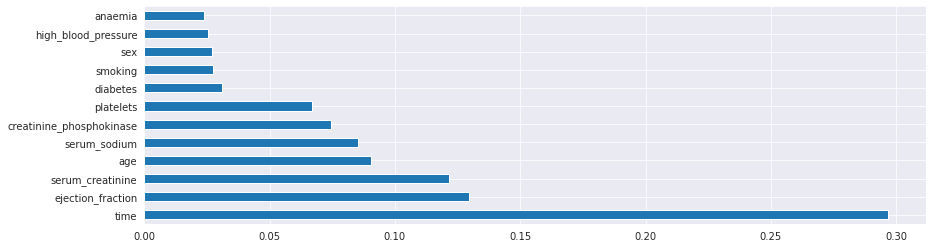

In [10]:
# Feature Selection - Redução de dimensionalidade 

plt.rcParams['figure.figsize']=14,4 
sns.set_style("darkgrid")

x = dataRaw.iloc[:, :-1]
y = dataRaw.iloc[:,-1]

model = ExtraTreesClassifier()
model.fit(x,y)

print(model.feature_importances_) 

feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(12).plot(kind='barh')

plt.show()

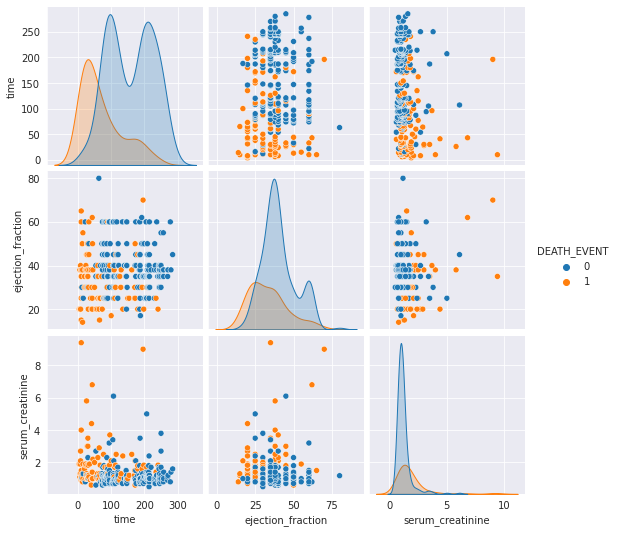

In [11]:
#plot dos Feutures

sns.pairplot(dataRaw[['time','ejection_fraction','serum_creatinine', 'DEATH_EVENT']], hue = 'DEATH_EVENT' )

In [12]:
#Treino e Teste

Features = ['time','ejection_fraction','serum_creatinine']

x = dataRaw[Features]
y = dataRaw["DEATH_EVENT"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)

In [13]:
accuracy_list = [];

In [14]:
# logistic regression

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
log_reg_pred = log_reg.predict(x_test)
log_reg_acc = accuracy_score(y_test, log_reg_pred)
accuracy_list.append(100*log_reg_acc)

print("Accuracy of Logistic Regression is : ", "{:.2f}%".format(100* log_reg_acc))

Accuracy of Logistic Regression is :  88.89%


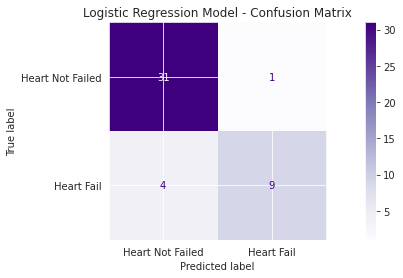

In [15]:
plot_confusion_matrix(log_reg, x_test, y_test, cmap=plt.cm.Purples)

plt.title("Logistic Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=10)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=10)
plt.show()

In [16]:
# Support Vector Machine

svm_clf = svm.SVC()
svm_clf.fit(x_train, y_train)
svm_clf_pred = svm_clf.predict(x_test)
svm_clf_acc = accuracy_score(y_test, svm_clf_pred)
accuracy_list.append(100* svm_clf_acc)

print("Accuracy of Support Vector Machine is : ", "{:.2f}%".format(100* svm_clf_acc))

Accuracy of Support Vector Machine is :  91.11%


<Figure size 1008x288 with 0 Axes>

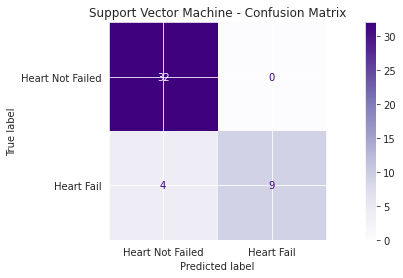

In [17]:
plt.figure()
plot_confusion_matrix(svm_clf, x_test, y_test, cmap=plt.cm.Purples)

plt.title("Support Vector Machine - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=10)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=10)
plt.show()

In [18]:
# K Neighbors Classifier

knn_clf = KNeighborsClassifier(n_neighbors=6)
knn_clf.fit(x_train, y_train)
knn_pred = knn_clf.predict(x_test)
knn_acc = accuracy_score(y_test, knn_pred)
accuracy_list.append(100*knn_acc)

print("Accuracy of K Neighbors Classifier is : ", "{:.2f}%".format(100* knn_acc))

Accuracy of K Neighbors Classifier is :  88.89%


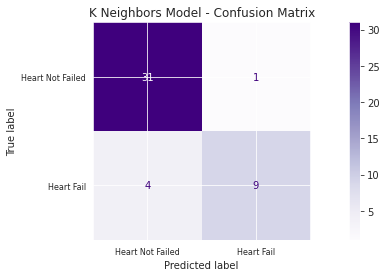

In [19]:
plot_confusion_matrix(knn_clf, x_test, y_test, cmap=plt.cm.Purples)
plt.title("K Neighbors Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=8)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=8)
plt.show()

In [20]:
# GradientBoostingClassifier

gradientboost_clf = GradientBoostingClassifier(max_depth=2, random_state=1)
gradientboost_clf.fit(x_train,y_train)
gradientboost_pred = gradientboost_clf.predict(x_test)
gradientboost_acc = accuracy_score(y_test, gradientboost_pred)
accuracy_list.append(100*gradientboost_acc)

print("Accuracy of Gradient Boosting is : ", "{:.2f}%".format(100* gradientboost_acc))

Accuracy of Gradient Boosting is :  95.56%


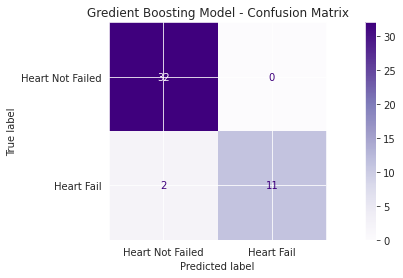

In [21]:
plot_confusion_matrix(gradientboost_clf, x_test, y_test, cmap=plt.cm.Purples)

plt.title("Gredient Boosting Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=10)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=10)
plt.show()

In [22]:
accuracy_list

[88.88888888888889, 91.11111111111111, 88.88888888888889, 95.55555555555556]